In [1]:
import random
import numpy as np
import torch
import os

GLOBAL_SEED = 42
fake_mode = not os.getenv('KAGGLE_IS_COMPETITION_RERUN')

def set_all_seeds(seed=GLOBAL_SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # 为了完全确定性，禁用CUDA的非确定性算法
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # 设置Python哈希种子
    os.environ['PYTHONHASHSEED'] = str(seed)

set_all_seeds()

In [2]:
import os
import sys
import time
import json
import importlib
import multiprocessing
from multiprocessing import Pool

import numpy as np
import torch

sys.path.append('/kaggle/input/darkagicompressarc')

# This little block of code does "import preprocessing" but avoids a name collision with another module
module_path = "/kaggle/input/darkagicompressarc/preprocessing.py"
module_name = "preprocessing"
spec = importlib.util.spec_from_file_location(module_name, module_path)
preprocessing = importlib.util.module_from_spec(spec)
sys.modules[module_name] = preprocessing
spec.loader.exec_module(preprocessing)
import train
import arc_compressor
import initializers
import multitensor_systems
import layers
import solution_selection
import visualization
import solve_task

In [3]:
multiprocessing.set_start_method('spawn', force=True)
torch.set_default_dtype(torch.float32)
torch.set_default_device('cuda')
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True

if __name__ == '__main__':

    start_time = time.time()
    end_time = start_time + 12*3600 - 1200

    n_cpus = multiprocessing.cpu_count()
    n_gpus = torch.cuda.device_count()

    # Find all the puzzle names
    split = "evaluation" if fake_mode else "test"
    with open(f'../input/arc-prize-2025/arc-agi_{split}_challenges.json', 'r') as f:
        problems = json.load(f)
    task_names = list(problems.keys())
    del problems
    n_tasks = len(task_names)

In [4]:
def parallelize_runs(gpu_quotas, task_usages, n_iterations, verbose=False):
    gpu_quotas = gpu_quotas[:]
    # Schedule the tasks greedily to max out memory usage
    t = time.time()
    tasks_started = [False for i in range(n_tasks)]
    tasks_finished = [False for i in range(n_tasks)]
    processes = [None for i in range(n_tasks)]
    process_gpu_ids = [None for i in range(n_tasks)]
    with multiprocessing.Manager() as manager:
        memory_dict = manager.dict()
        solutions_dict = manager.dict()
        error_queue = manager.Queue()
        while not all(tasks_finished):
            if not error_queue.empty():
                raise ValueError(error_queue.get())
            for i in range(n_tasks):
                if tasks_started[i] and not tasks_finished[i]:
                    processes[i].join(timeout=0)
                    if not processes[i].is_alive():
                        tasks_finished[i] = True
                        gpu_quotas[process_gpu_ids[i]] += task_usages[i]
                        if verbose:
                            print(task_names[i], 'finished on gpu', process_gpu_ids[i],
                                  'New quota is', gpu_quotas[process_gpu_ids[i]])
            for gpu_id in range(n_gpus):
                for i in range(n_tasks):
                    enough_quota = gpu_quotas[gpu_id] > task_usages[i]
                    enough_cpus = sum(map(int, tasks_started)) - sum(map(int, tasks_finished)) < n_cpus
                    if not tasks_started[i] and enough_quota and enough_cpus:
                        gpu_quotas[gpu_id] -= task_usages[i]
                        args = (task_names[i], split, end_time, n_iterations, gpu_id, memory_dict, solutions_dict, error_queue)
                        p = multiprocessing.Process(target=solve_task.solve_task, args=args)
                        p.start()
                        processes[i] = p
                        tasks_started[i] = True
                        process_gpu_ids[i] = gpu_id
                        if verbose:
                            print(task_names[i], 'started on gpu', process_gpu_ids[i],
                                  'New quota is', gpu_quotas[process_gpu_ids[i]])
            time.sleep(1)
        if not error_queue.empty():
            raise ValueError(error_queue.get())
        memory_dict = dict(memory_dict)
        solutions_dict = dict(solutions_dict)
    time_taken = time.time() - t
    if verbose:
        print('All jobs finished in', time_taken, 'seconds.')
    return memory_dict, solutions_dict, time_taken

In [5]:
if __name__ == '__main__':
    gpu_memory_quotas = [torch.cuda.mem_get_info(i)[0] for i in range(n_gpus)]

    gpu_task_quotas = [int(gpu_memory_quota // (4 * 1024**3)) for gpu_memory_quota in gpu_memory_quotas]
    task_usages = [1 for i in range(n_tasks)]
    memory_dict, _, _ = parallelize_runs(gpu_task_quotas, task_usages, 2, verbose=False)
    
    # Sort the tasks by decreasing memory usage
    tasks = sorted(memory_dict.items(), key=lambda x: x[1], reverse=True)
    task_names, task_memory_usages = zip(*tasks)

In [6]:
if __name__ == '__main__':
    test_steps = 5 if fake_mode else 20
    safe_gpu_memory_quotas = [memory_quota - 6 * 1024**3 for memory_quota in gpu_memory_quotas]
    _, _, time_taken = parallelize_runs(safe_gpu_memory_quotas, task_memory_usages, test_steps, verbose=False)

In [7]:
if __name__ == '__main__':
    time_per_step = time_taken / test_steps
    time_left = end_time - time.time()
    n_steps = 5 if fake_mode else int(time_left // time_per_step)
    _, solutions_dict, time_taken = parallelize_runs(safe_gpu_memory_quotas, task_memory_usages, n_steps, verbose=True)
    
    # Format the solutions and put into submission file
    with open('submission.json', 'w') as f:
        json.dump(solutions_dict, f, indent=4)
        
    print(n_tasks, 'tasks solved.')
    print(n_steps, 'steps taken.')
    print(time_taken, 'seconds taken.')


8b7bacbf started on gpu 0 New quota is 12189925376
21897d95 started on gpu 0 New quota is 7105257472
88bcf3b4 started on gpu 0 New quota is 2280357888
b99e7126 started on gpu 0 New quota is 38895616
e12f9a14 started on gpu 1 New quota is 12693920256
d8e07eb2 started on gpu 1 New quota is 8244157952
b0039139 started on gpu 1 New quota is 3970566656
195c6913 started on gpu 1 New quota is 110190592
13e47133 started on gpu 2 New quota is 13039332864
3e6067c3 started on gpu 2 New quota is 8798788608
a32d8b75 started on gpu 2 New quota is 4558244352
981571dc started on gpu 2 New quota is 317735936
28a6681f started on gpu 2 New quota is 15080960
20a9e565 started on gpu 3 New quota is 13043785216
0934a4d8 started on gpu 3 New quota is 8807729152
a25697e4 started on gpu 3 New quota is 4947353088
291dc1e1 started on gpu 3 New quota is 1213989376
53fb4810 started on gpu 3 New quota is 24997376
b99e7126 finished on gpu 0 New quota is 2280357888
7c66cb00 started on gpu 0 New quota is 77768192
d8e07


VISUALIZING ARC SOLUTION RESULTS
Found submission file: submission.json
Loaded submission with 120 tasks

Found 172 total predictions to visualize
Showing 10 of 172 prediction samples

Task: b99e7126 - Test #1 (all zeros - no score)
  Skipping visualization for Task b99e7126 - Test #1 (all predictions are zeros)

Task: 28a6681f - Test #1 (Score: 0/2)
  Results: Attempt 1: ✗, Attempt 2: ✗
  Shape - Ground Truth: (10, 10), Prediction 1: (10, 10), Prediction 2: (10, 10)
  Values - Ground Truth unique values: [0 1 3 5 9]
          Prediction 1 unique values: [2]
          Prediction 2 unique values: [1 3 5 9]


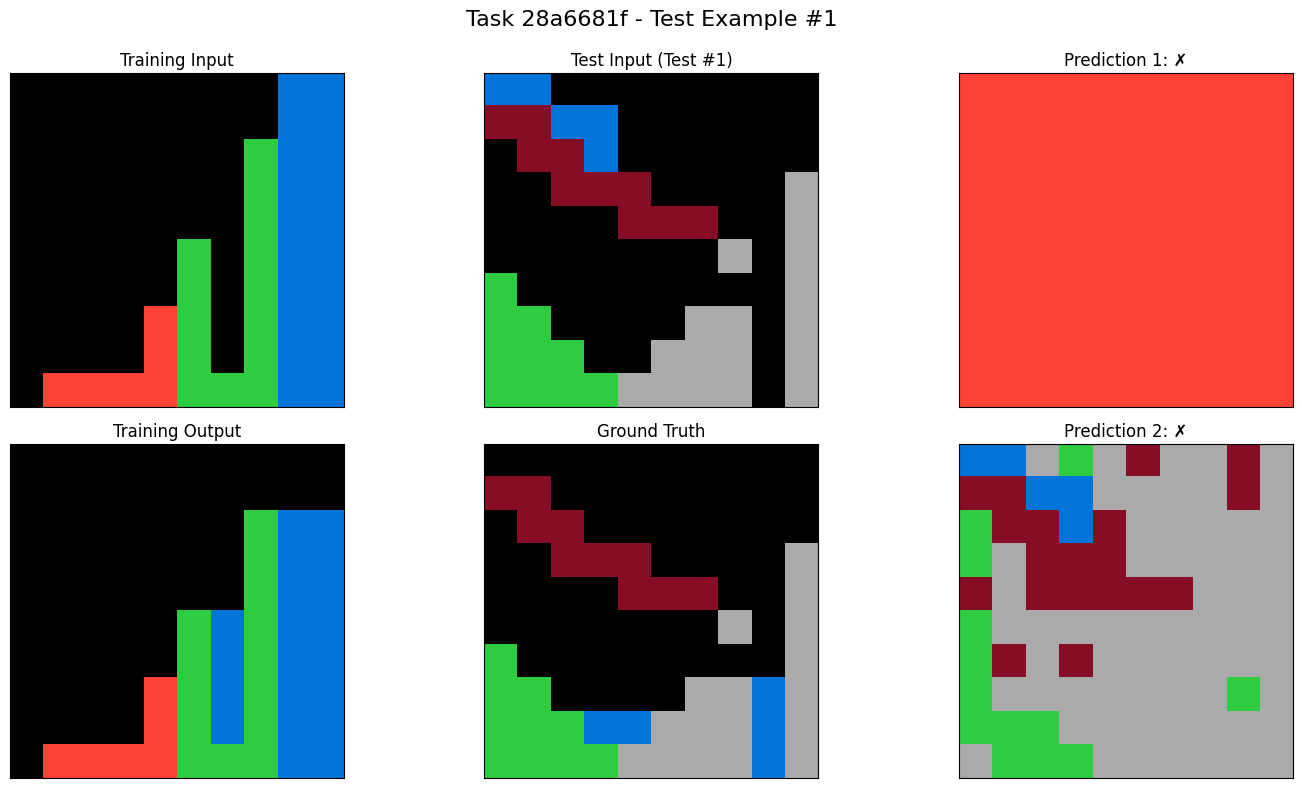


Task: d8e07eb2 - Test #1 (all zeros - no score)
  Skipping visualization for Task d8e07eb2 - Test #1 (all predictions are zeros)

Task: d8e07eb2 - Test #2 (all zeros - no score)
  Skipping visualization for Task d8e07eb2 - Test #2 (all predictions are zeros)

Task: 53fb4810 - Test #1 (all zeros - no score)
  Skipping visualization for Task 53fb4810 - Test #1 (all predictions are zeros)

Task: 981571dc - Test #1 (all zeros - no score)
  Skipping visualization for Task 981571dc - Test #1 (all predictions are zeros)

Task: 195c6913 - Test #1 (Score: 0/2)
  Results: Attempt 1: ✗, Attempt 2: ✗
  Shape - Ground Truth: (30, 30), Prediction 1: (30, 30), Prediction 2: (30, 30)
  Values - Ground Truth unique values: [1 2 3 4 6 7 8]
          Prediction 1 unique values: [4 7]
          Prediction 2 unique values: [4 7]


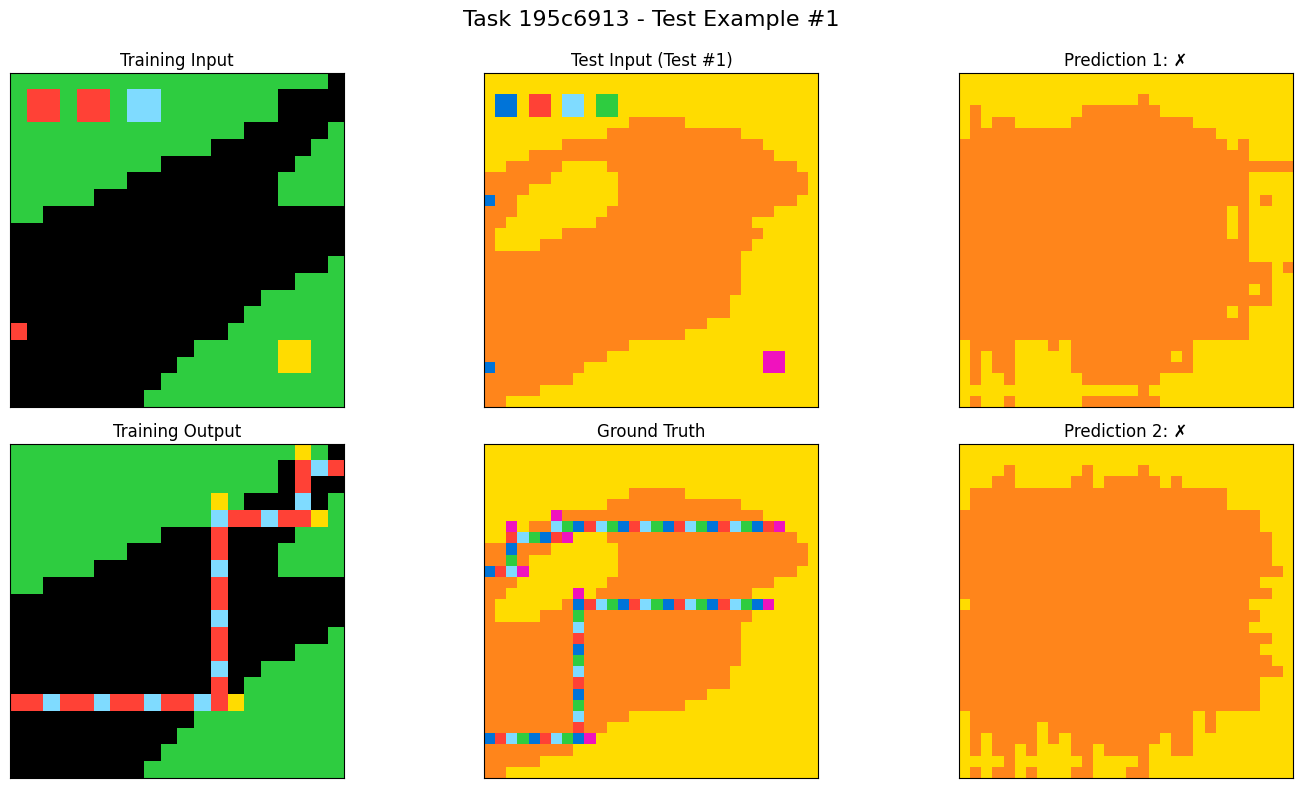


Task: 195c6913 - Test #2 (Score: 0/2)
  Results: Attempt 1: ✗, Attempt 2: ✗
  Shape - Ground Truth: (30, 30), Prediction 1: (30, 30), Prediction 2: (30, 30)
  Values - Ground Truth unique values: [3 6 7 8 9]
          Prediction 1 unique values: [8 9]
          Prediction 2 unique values: [9]


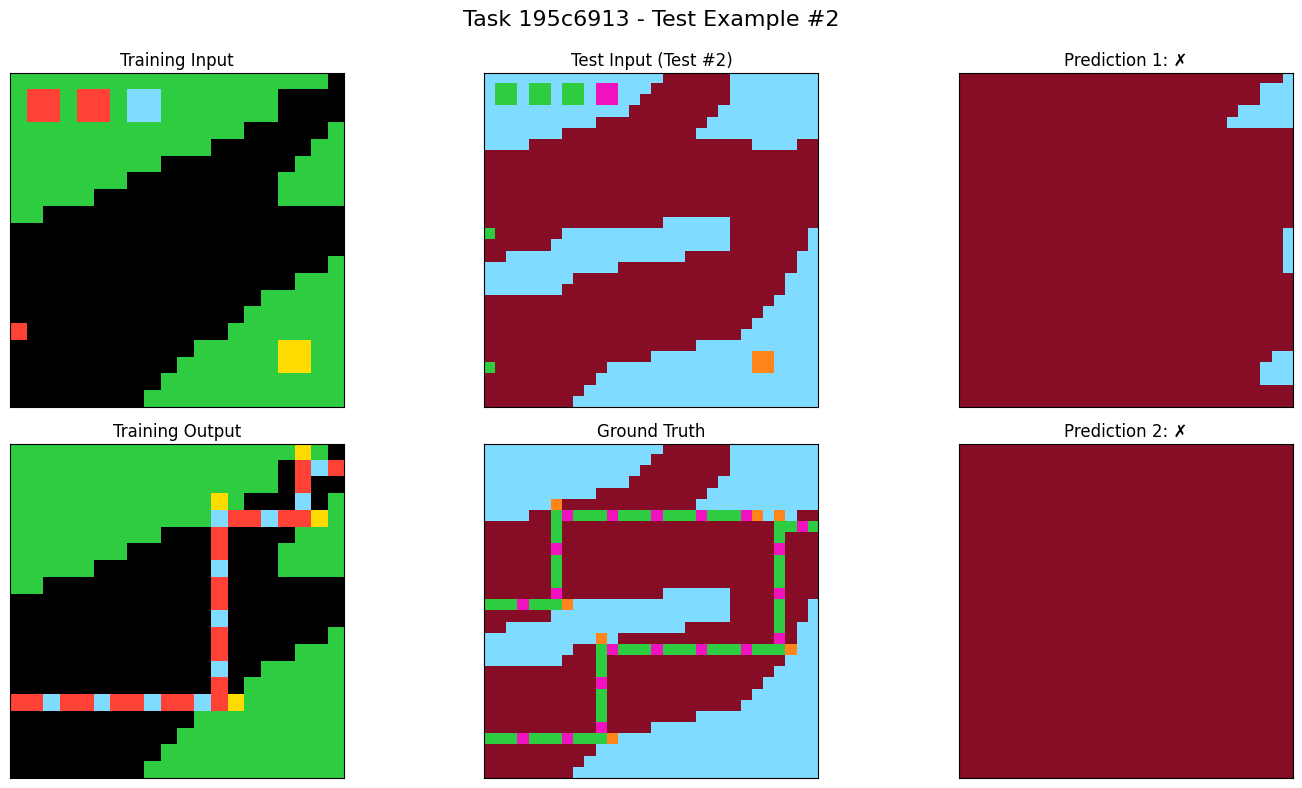


Task: a25697e4 - Test #1 (Score: 0/2)
  Results: Attempt 1: ✗, Attempt 2: ✗
  Shape - Ground Truth: (30, 30), Prediction 1: (30, 30), Prediction 2: (30, 30)
  Values - Ground Truth unique values: [1 2 3 4]
          Prediction 1 unique values: [4]
          Prediction 2 unique values: [1 2 3 4 5 6 7 8]


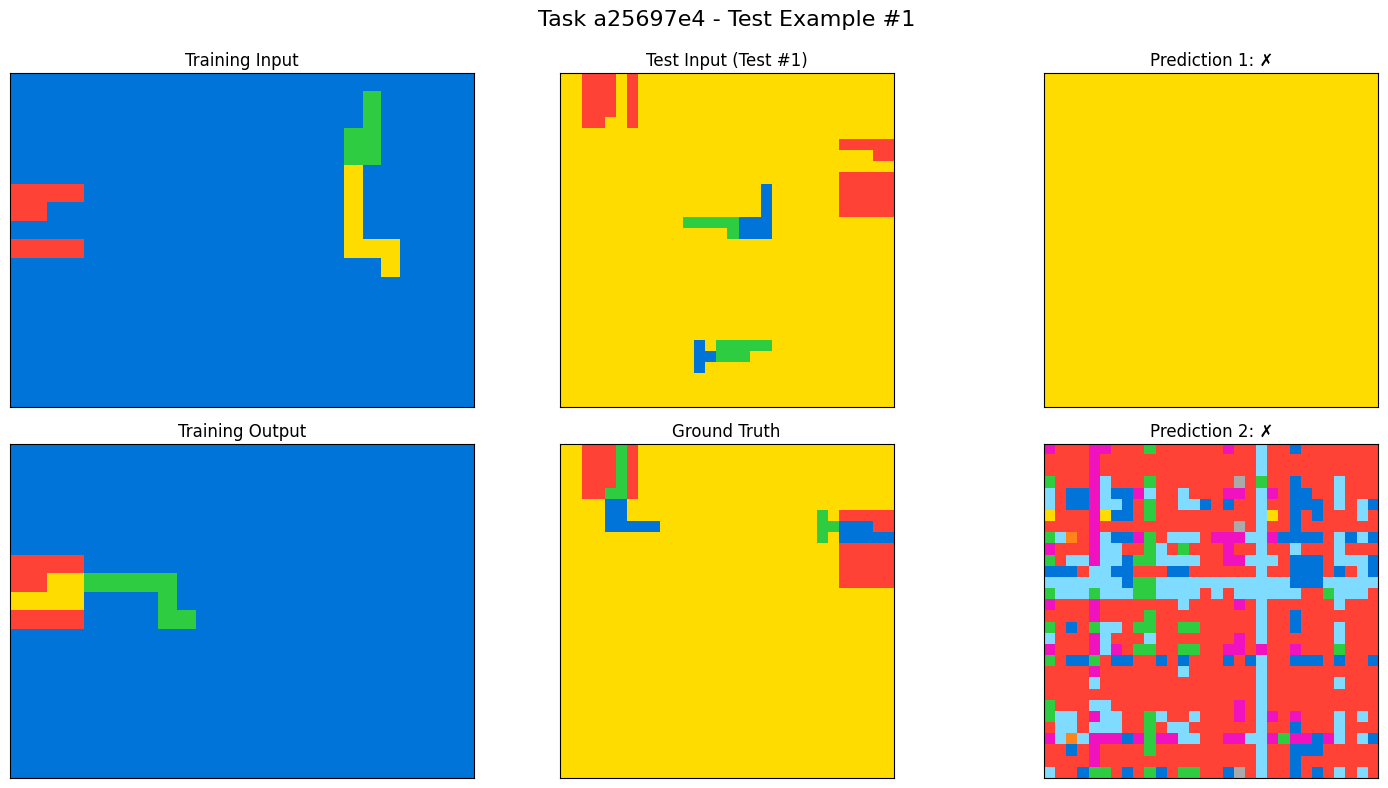


Task: a25697e4 - Test #2 (Score: 0/2)
  Results: Attempt 1: ✗, Attempt 2: ✗
  Shape - Ground Truth: (30, 25), Prediction 1: (30, 25), Prediction 2: (30, 25)
  Values - Ground Truth unique values: [2 3 4 6 7 8]
          Prediction 1 unique values: [8]
          Prediction 2 unique values: [1 2 3 4 6 7 8]


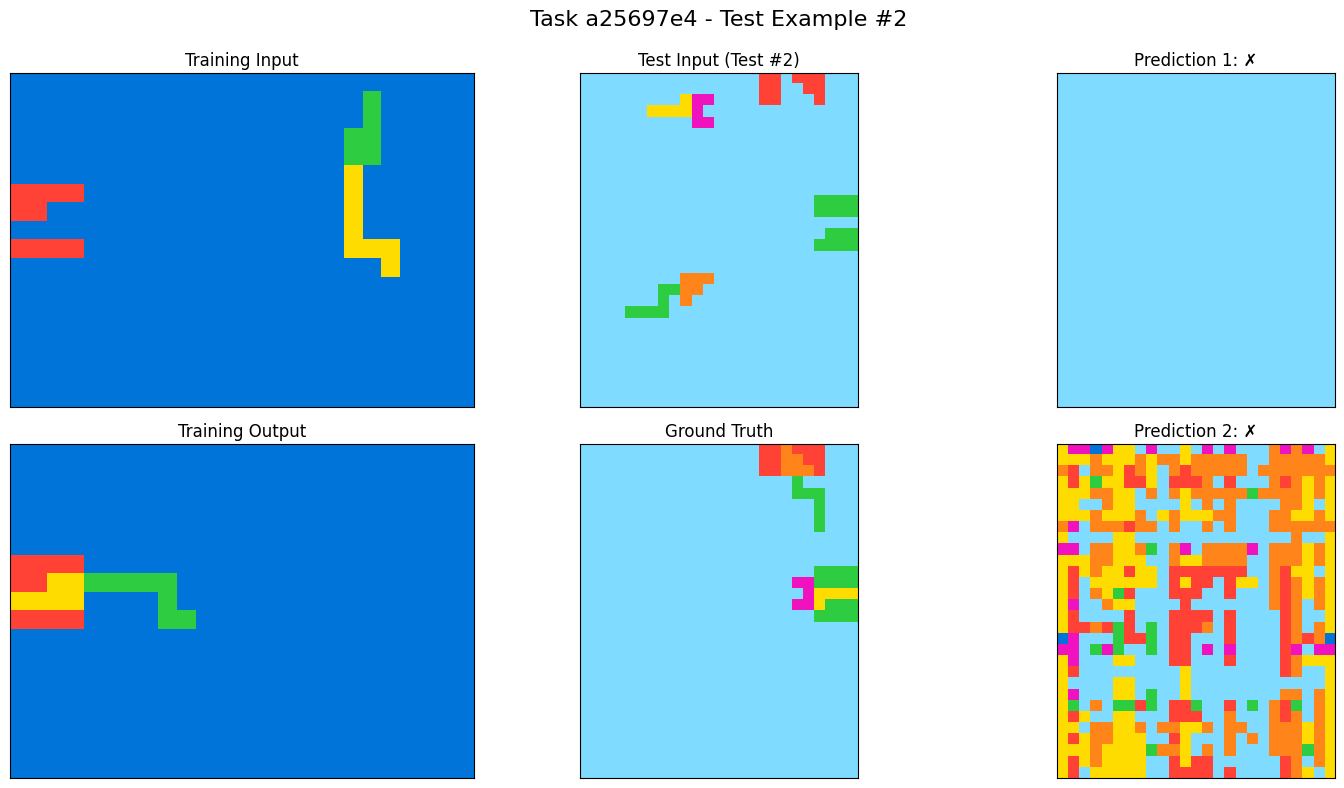


Visualized 5 inference results (skipped 5 with all-zero predictions)

OVERALL ACCURACY STATISTICS
Total test examples: 172
Test examples with zero predictions (excluded from accuracy): 101
Test examples included in accuracy calculation: 71
Correct on attempt 1: 0/71 (0.00%)
Correct on attempt 2: 0/71 (0.00%)
Correct on either attempt: 0/71 (0.00%)
Overall completion rate: 41.28% of tests have non-zero predictions


In [8]:
# Add visualization functions to the notebook
import json
training_solution_path = '/kaggle/input/arc-prize-2025/arc-agi_training_solutions.json'
with open(training_solution_path, 'r') as f:
    training_solution = json.load(f)
evaluation_solution_path = '/kaggle/input/arc-prize-2025/arc-agi_evaluation_solutions.json'
with open(evaluation_solution_path, 'r') as f:
    evaluation_solution = json.load(f)
conbiled_solution = {}

if fake_mode:
    arc_challenge_file = '/kaggle/input/arc-prize-2025/arc-agi_evaluation_challenges.json'
else:
    arc_challenge_file = '/kaggle/input/arc-prize-2025/arc-agi_test_challenges.json'
    
with open(arc_challenge_file, 'r') as f:
    arc_data = json.load(f)
    
for case_id in arc_data:
    if case_id in training_solution:
        conbiled_solution[case_id] = training_solution[case_id][0]
    elif case_id in evaluation_solution:
        conbiled_solution[case_id] = evaluation_solution[case_id][0]
        
    
def visualize_arc_results():
    """Visualize ARC problem solutions from submission.json"""
    import matplotlib.pyplot as plt
    from matplotlib import colors
    import json
    import os
    import numpy as np
    
    print("\n" + "="*80)
    print("VISUALIZING ARC SOLUTION RESULTS")
    print("="*80)
    
    # Check if submission file exists
    submission_path = 'submission.json'
    if not os.path.exists(submission_path):
        print(f"Submission file not found at {submission_path}")
        return
    
    print(f"Found submission file: {submission_path}")
    
    # Load submission data
    with open(submission_path, 'r') as f:
        submission_data = json.load(f)
    
    print(f"Loaded submission with {len(submission_data)} tasks")
    
    # ARC color map - colors for values 0-9
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    
    # Function to check if prediction is non-trivial (not just zeros)
    def is_non_trivial_prediction(pred_array):
        # Check if the prediction contains any non-zero values
        return np.any(np.array(pred_array) > 0)
    
    # Function to visualize a single task result
    def visualize_submission_result(task_id, task_data, submission_output, test_idx):
        # Skip visualization if both predictions are just zeros
        pred_1 = np.array(submission_output['attempt_1'])
        pred_2 = np.array(submission_output['attempt_2'])
        
        if not is_non_trivial_prediction(pred_1) and not is_non_trivial_prediction(pred_2):
            print(f"  Skipping visualization for Task {task_id} - Test #{test_idx+1} (all predictions are zeros)")
            return False
        
        # Create visualization
        fig = plt.figure(figsize=(15, 8))
        grid_spec = plt.GridSpec(2, 3, width_ratios=[1, 1, 1])
        
        # Training examples (first one only for simplicity)
        if task_data['train']:
            # Train Input
            ax1 = fig.add_subplot(grid_spec[0, 0])
            ax1.imshow(task_data['train'][0]['input'], cmap=cmap, norm=norm)
            ax1.grid(True, which='both', color='lightgrey', linewidth=0.5)
            ax1.set_title("Training Input")
            ax1.set_xticks([])
            ax1.set_yticks([])
            
            # Train Output
            ax2 = fig.add_subplot(grid_spec[1, 0])
            ax2.imshow(task_data['train'][0]['output'], cmap=cmap, norm=norm)
            ax2.grid(True, which='both', color='lightgrey', linewidth=0.5)
            ax2.set_title("Training Output")
            ax2.set_xticks([])
            ax2.set_yticks([])
        
        # Test Input
        if test_idx < len(task_data['test']):
            ax3 = fig.add_subplot(grid_spec[0, 1])
            ax3.imshow(task_data['test'][test_idx]['input'], cmap=cmap, norm=norm)
            ax3.grid(True, which='both', color='lightgrey', linewidth=0.5)
            ax3.set_title(f"Test Input (Test #{test_idx+1})")
            ax3.set_xticks([])
            ax3.set_yticks([])
        
        # Model Predictions
        # Attempt 1
        ax5 = fig.add_subplot(grid_spec[0, 2])
        ax5.imshow(pred_1, cmap=cmap, norm=norm)
        ax5.grid(True, which='both', color='lightgrey', linewidth=0.5)
        ax5.set_title("Model Prediction (Attempt 1)")
        ax5.set_xticks([])
        ax5.set_yticks([])
        
        # Attempt 2
        ax6 = fig.add_subplot(grid_spec[1, 2])
        ax6.imshow(pred_2, cmap=cmap, norm=norm)
        ax6.grid(True, which='both', color='lightgrey', linewidth=0.5)
        ax6.set_title("Model Prediction (Attempt 2)")
        ax6.set_xticks([])
        ax6.set_yticks([])
        
        # If ground truth is available and we're in fake/debug mode
        if (task_id in arc_data) and (task_id in training_solution or task_id in evaluation_solution):
            # Get ground truth
            ground_truth = None
            if task_id in training_solution and len(training_solution[task_id]) > test_idx:
                ground_truth = training_solution[task_id][test_idx]
            elif task_id in evaluation_solution and len(evaluation_solution[task_id]) > test_idx:
                ground_truth = evaluation_solution[task_id][test_idx]
                
            if ground_truth:
                ax4 = fig.add_subplot(grid_spec[1, 1])
                ax4.imshow(ground_truth, cmap=cmap, norm=norm)
                ax4.grid(True, which='both', color='lightgrey', linewidth=0.5)
                ax4.set_title("Ground Truth")
                ax4.set_xticks([])
                ax4.set_yticks([])
                
                # Calculate match information
                match_1 = np.array_equal(pred_1, ground_truth) if is_non_trivial_prediction(pred_1) else False
                match_2 = np.array_equal(pred_2, ground_truth) if is_non_trivial_prediction(pred_2) else False
                
                # Add match indicators to prediction titles
                ax5.set_title(f"Prediction 1: {'✓' if match_1 else '✗'}")
                ax6.set_title(f"Prediction 2: {'✓' if match_2 else '✗'}")
                
                # Display match information
                print(f"  Results: Attempt 1: {'✓' if match_1 else '✗'}, Attempt 2: {'✓' if match_2 else '✗'}")
                print(f"  Shape - Ground Truth: {np.array(ground_truth).shape}, "
                      f"Prediction 1: {pred_1.shape}, Prediction 2: {pred_2.shape}")
                print(f"  Values - Ground Truth unique values: {np.unique(ground_truth)}")
                print(f"          Prediction 1 unique values: {np.unique(pred_1)}")
                print(f"          Prediction 2 unique values: {np.unique(pred_2)}")
        
        plt.suptitle(f"Task {task_id} - Test Example #{test_idx+1}", fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()
        return True
    
    # Process all results from submission
    visualized_count = 0
    skipped_count = 0
    
    # Create a list of all tasks and their test indices
    all_predictions = []
    for task_id in submission_data:
        if task_id in arc_data:
            task_data = arc_data[task_id]
            for test_idx, test_prediction in enumerate(submission_data[task_id]):
                # Check if predictions are non-trivial
                pred_1 = np.array(test_prediction['attempt_1'])
                pred_2 = np.array(test_prediction['attempt_2'])
                has_non_zero_pred = is_non_trivial_prediction(pred_1) or is_non_trivial_prediction(pred_2)
                
                # Check if we have ground truth available
                has_ground_truth = False
                correct_count = 0
                
                if task_id in training_solution and len(training_solution[task_id]) > test_idx:
                    has_ground_truth = True
                    ground_truth = training_solution[task_id][test_idx]
                    
                    if has_non_zero_pred:
                        match_1 = np.array_equal(pred_1, ground_truth) if is_non_trivial_prediction(pred_1) else False
                        match_2 = np.array_equal(pred_2, ground_truth) if is_non_trivial_prediction(pred_2) else False
                        correct_count = int(match_1) + int(match_2)
                
                elif task_id in evaluation_solution and len(evaluation_solution[task_id]) > test_idx:
                    has_ground_truth = True
                    ground_truth = evaluation_solution[task_id][test_idx]
                    
                    if has_non_zero_pred:
                        match_1 = np.array_equal(pred_1, ground_truth) if is_non_trivial_prediction(pred_1) else False
                        match_2 = np.array_equal(pred_2, ground_truth) if is_non_trivial_prediction(pred_2) else False
                        correct_count = int(match_1) + int(match_2)
                
                all_predictions.append((task_id, test_idx, correct_count, has_ground_truth, has_non_zero_pred))
    
    # Sort predictions by correctness and ground truth availability
    all_predictions.sort(key=lambda x: (-int(x[3]), -x[2]))
    
    print(f"\nFound {len(all_predictions)} total predictions to visualize")
    
    # Limit visualization to first N samples for performance
    max_samples = 10  # Change this number to see more or fewer examples
    samples_to_show = all_predictions[:max_samples]
    
    print(f"Showing {len(samples_to_show)} of {len(all_predictions)} prediction samples")
    
    # Visualize selected predictions
    for task_id, test_idx, correct_count, has_ground_truth, has_non_zero_pred in samples_to_show:
        task_data = arc_data[task_id]
        submission_output = submission_data[task_id][test_idx]
        
        # Visualize this task
        score_info = f" (Score: {correct_count}/2)" if has_ground_truth and has_non_zero_pred else " (no ground truth)" if not has_ground_truth else " (all zeros - no score)"
        print(f"\nTask: {task_id} - Test #{test_idx+1}{score_info}")
        
        # Only increment visualized_count if actually visualized
        if visualize_submission_result(task_id, task_data, submission_output, test_idx):
            visualized_count += 1
        else:
            skipped_count += 1
    
    print(f"\nVisualized {visualized_count} inference results (skipped {skipped_count} with all-zero predictions)")
    
    # Calculate overall accuracy statistics if in fake/debug mode
    if fake_mode:  # Only run statistics in debug/local mode
        total_tests = 0
        total_scored_tests = 0
        correct_attempt1 = 0
        correct_attempt2 = 0
        correct_any = 0
        zero_predictions = 0
        
        for task_id, test_idx, _, has_ground_truth, _ in all_predictions:
            if has_ground_truth:
                total_tests += 1
                
                # Get ground truth
                ground_truth = None
                if task_id in training_solution and len(training_solution[task_id]) > test_idx:
                    ground_truth = training_solution[task_id][test_idx]
                elif task_id in evaluation_solution and len(evaluation_solution[task_id]) > test_idx:
                    ground_truth = evaluation_solution[task_id][test_idx]
                
                if not ground_truth:
                    continue
                    
                pred_1 = np.array(submission_data[task_id][test_idx]['attempt_1'])
                pred_2 = np.array(submission_data[task_id][test_idx]['attempt_2'])
                
                # Check if both predictions are all zeros
                if not is_non_trivial_prediction(pred_1) and not is_non_trivial_prediction(pred_2):
                    zero_predictions += 1
                    continue
                
                # Only count tests with at least one non-zero prediction
                total_scored_tests += 1
                
                match_1 = np.array_equal(pred_1, ground_truth) if is_non_trivial_prediction(pred_1) else False
                match_2 = np.array_equal(pred_2, ground_truth) if is_non_trivial_prediction(pred_2) else False
                
                if match_1: correct_attempt1 += 1
                if match_2: correct_attempt2 += 1
                if match_1 or match_2: correct_any += 1
        
        if total_tests > 0:
            print("\n" + "="*80)
            print("OVERALL ACCURACY STATISTICS")
            print("="*80)
            print(f"Total test examples: {total_tests}")
            print(f"Test examples with zero predictions (excluded from accuracy): {zero_predictions}")
            print(f"Test examples included in accuracy calculation: {total_scored_tests}")
            
            if total_scored_tests > 0:
                print(f"Correct on attempt 1: {correct_attempt1}/{total_scored_tests} ({correct_attempt1/total_scored_tests:.2%})")
                print(f"Correct on attempt 2: {correct_attempt2}/{total_scored_tests} ({correct_attempt2/total_scored_tests:.2%})")
                print(f"Correct on either attempt: {correct_any}/{total_scored_tests} ({correct_any/total_scored_tests:.2%})")
            else:
                print("No non-zero predictions to calculate accuracy")
                
            print(f"Overall completion rate: {total_scored_tests/total_tests:.2%} of tests have non-zero predictions")
            print("="*80)

# Add this line to the notebook to call the visualization function
# Call after your submission.json has been created
if fake_mode:
    visualize_arc_results()